# line plot for wa

In [25]:
MODELS = ["BLUEBERT-EFO", "BlueBERT", "BioSentVec"]

top_n_list = [1, 3, 5, 8, 10, 15]

model_collection = {
    k: v for k, v in info_stage2.model_collection.items() if k in MODELS
}
df_list = []
for top_n in top_n_list:
    df = mapping_routine.prep_weighted_average_df_new(
        model_collection=model_collection, top_num=top_n
    )
    df_list.append(df)

2022-12-19 14:35:29.695 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BLUEBERT-EFO
2022-12-19 14:35:30.362 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BioSentVec
2022-12-19 14:35:30.952 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BlueBERT
2022-12-19 14:35:31.540 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BLUEBERT-EFO
2022-12-19 14:35:32.094 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BioSentVec
2022-12-19 14:35:32.816 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BlueBERT
2022-12-19 14:35:33.374 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BLUEBERT-EFO
2022-12-19 14:35:33.985 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BioSentVec
2022-12-19 14:35:34.635 | INFO     | funcs.data_processing.mapping_routine:_calc_wa_df:140 - BlueBERT
2022-12-19 14:35:35.235 | INFO     | funcs.data_processing.mappi

In [26]:
df_list[0]

,mapping_id,value,Model
0,1,0.412,BLUEBERT-EFO
1,2,0.185,BLUEBERT-EFO
2,3,0.714,BLUEBERT-EFO
3,4,0.071,BLUEBERT-EFO
4,5,0.800,BLUEBERT-EFO
...,...,...,...
3568,1187,0.889,BlueBERT
3569,1188,0.667,BlueBERT
3570,1189,0.556,BlueBERT
3571,1190,1.000,BlueBERT


In [27]:
df_x = []
for idx, top_n in enumerate(top_n_list):
    df = (
        df_list[idx]
        .groupby(["Model"])
        .apply(lambda df: pd.Series({"value": df["value"].sum() / len(df)}))
        .assign(top_n=top_n)
    )
    df_x.append(df)
df_x = pd.concat(df_x).reset_index(drop=False).rename(columns={"Model": "Method"})
df_x

,Method,value,top_n
0,BLUEBERT-EFO,0.694458,1
1,BioSentVec,0.631194,1
2,BlueBERT,0.572683,1
3,BLUEBERT-EFO,0.634671,3
4,BioSentVec,0.547907,3
5,BlueBERT,0.492265,3
6,BLUEBERT-EFO,0.601409,5
7,BioSentVec,0.507596,5
8,BlueBERT,0.453935,5
9,BLUEBERT-EFO,0.568596,8


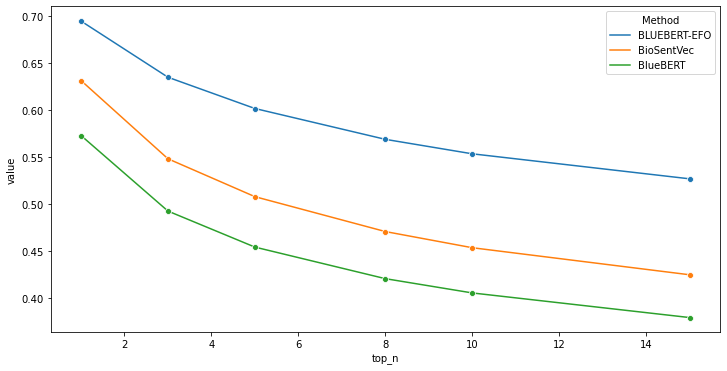

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_x, x="top_n", y="value", hue="Method", marker="o")

output_file = output_dir / "wa-line.png"
plt.savefig(output_file, dpi=1000)

# line plot with biosentvec prefilter

In [266]:
biosentvec_top100_path = info_stage2.model_collection["BioSentVec"]["top_100"]
assert biosentvec_top100_path.exists(), biosentvec_top100_path
bluebert_efo_top100_path = info_stage2.model_collection["BLUEBERT-EFO"]["top_100"]
assert bluebert_efo_top100_path.exists(), bluebert_efo_top100_path

In [267]:
biosentvec_top100 = pd.read_csv(biosentvec_top100_path)
biosentvec_top100.info()
bluebert_efo_top100 = pd.read_csv(bluebert_efo_top100_path)
bluebert_efo_top100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119100 entries, 0 to 119099
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mapping_id  119100 non-null  int64  
 1   manual      119100 non-null  object 
 2   prediction  119100 non-null  object 
 3   score       118700 non-null  float64
 4   nx          119100 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118711 entries, 0 to 118710
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mapping_id  118711 non-null  int64  
 1   manual      118711 non-null  object 
 2   prediction  118711 non-null  object 
 3   score       118711 non-null  float64
 4   nx          118711 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ MB


In [289]:
NUM_CANDS_STAGE1 = [20, 30, 50]
NUM_CANDS_STAGE2 = top_n_list

In [290]:
def _calc_weighted_avg(df, num_cands):
    nx_scores = (
        df.sort_values(by=["score"], ascending=True)["nx"].head(num_cands).tolist()
    )
    weights = list(reversed(range(1, (len(nx_scores) + 1))))
    wa = round(np.average(nx_scores, weights=weights), 3)
    res_df = pd.DataFrame({"manual": [df["manual"].tolist()[0]], "value": wa})
    return res_df


df_all = []
df_sum = []
for top_n_stage1 in NUM_CANDS_STAGE1:
    df_stage1 = (
        # biosentvec_top100.groupby(["mapping_id"])
        biosentvec_top100.groupby(["manual"])
        .apply(lambda df: df.head(top_n_stage1))
        .reset_index(drop=True)
    )
    df_stage2 = (
        df_stage1.drop(columns=["score", "nx"])
        .merge(
            bluebert_efo_top100.drop(columns="manual"), on=["mapping_id", "prediction"]
        )
        .sort_values(by=["mapping_id", "score"], ascending=[True, True])
    )
    df_stage3_all = []
    for top_n_stage2 in NUM_CANDS_STAGE2:
        df = (
            df_stage2.groupby(["manual"])
            .apply(lambda df: _calc_weighted_avg(df, num_cands=top_n_stage2))
            .assign(top_n_stage2=top_n_stage2)
            .assign(top_n_stage1=top_n_stage1)
            .assign(
                top_n=lambda df: df["top_n_stage2"],
            )
            .assign(
                Method=lambda df: df.apply(
                    lambda row: "BioSentVec-{top_n}-BLUEBERT-EFO".format(
                        top_n=int(row["top_n_stage1"])
                    ),
                    axis=1,
                ),
            )
        ).reset_index(drop=True)
        df_stage3_all.append(df)

    df_stage3_all = pd.concat(df_stage3_all)
    df_all.append(df_stage3_all)
    df_stage3_sum = df_stage3_all.groupby(["Method", "top_n"]).apply(
        lambda df: pd.Series({"value": df["value"].sum() / len(df)})
    )
    df_sum.append(df_stage3_sum)

df_all = pd.concat(df_all)
df_sum = pd.concat(df_sum).reset_index(drop=False)
df_all.info()
df_sum.info()
df_sum

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734 entries, 0 to 774
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manual        13734 non-null  object 
 1   value         13734 non-null  float64
 2   top_n_stage2  13734 non-null  int64  
 3   top_n_stage1  13734 non-null  int64  
 4   top_n         13734 non-null  int64  
 5   Method        13734 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 751.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Method  18 non-null     object 
 1   top_n   18 non-null     int64  
 2   value   18 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 560.0+ bytes


,Method,top_n,value
0,BioSentVec-20-BLUEBERT-EFO,1,0.750272
1,BioSentVec-20-BLUEBERT-EFO,3,0.685993
2,BioSentVec-20-BLUEBERT-EFO,5,0.659150
3,BioSentVec-20-BLUEBERT-EFO,8,0.643334
4,BioSentVec-20-BLUEBERT-EFO,10,0.638908
5,BioSentVec-20-BLUEBERT-EFO,15,0.635685
6,BioSentVec-30-BLUEBERT-EFO,1,0.739682
7,BioSentVec-30-BLUEBERT-EFO,3,0.675587
8,BioSentVec-30-BLUEBERT-EFO,5,0.646378
9,BioSentVec-30-BLUEBERT-EFO,8,0.626501


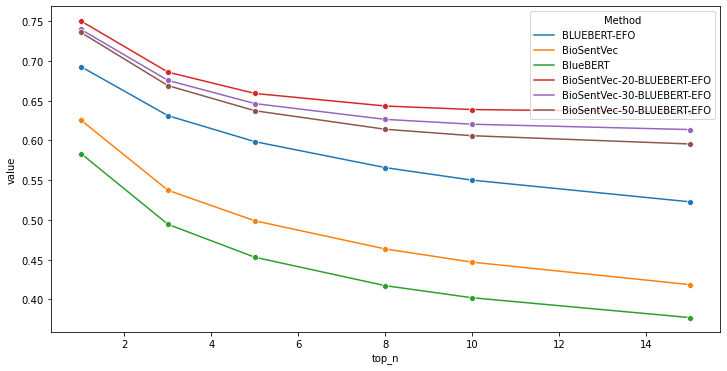

In [291]:
df_plot = pd.concat([df_x, df_sum]).reset_index(drop=True)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="top_n", y="value", hue="Method", marker="o")


output_file = output_dir / "wa-addon-line.png"
plt.savefig(output_file, dpi=1000)

# add on density plot

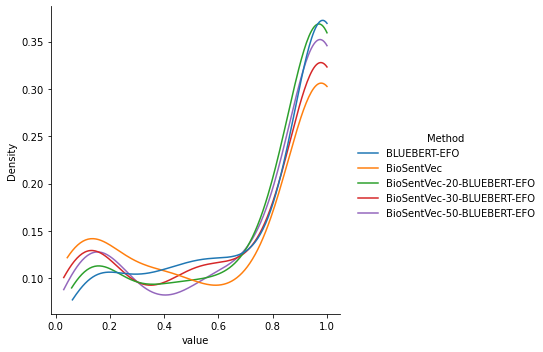

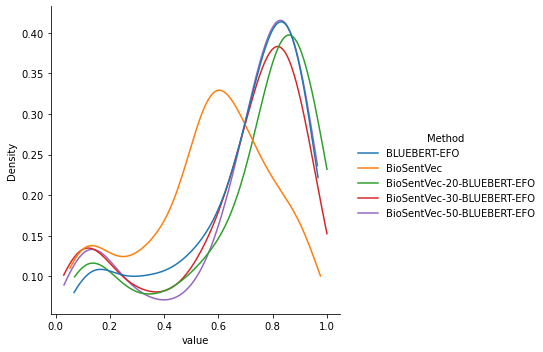

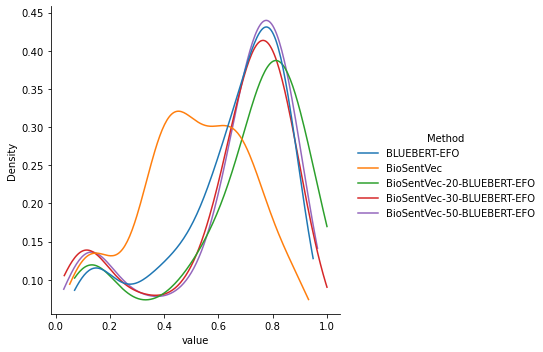

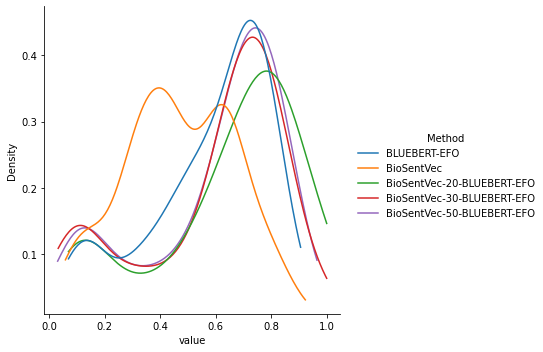

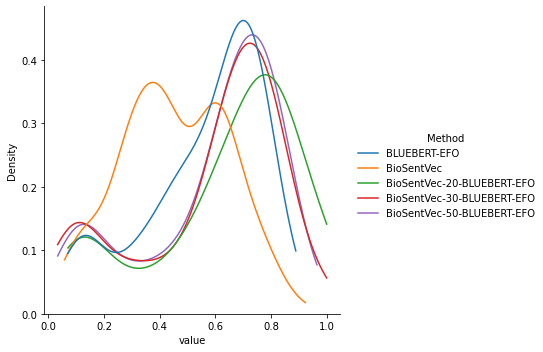

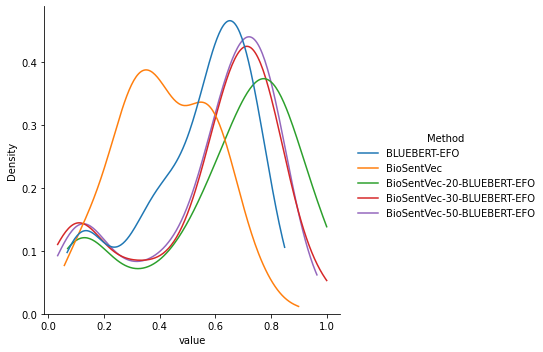

In [292]:
for idx, top_n in enumerate(top_n_list):
    df_base = (
        df_list[idx]
        .query('Model in ["BLUEBERT-EFO", "BioSentVec"]')
        .rename(columns={"Model": "Method"})
        .reset_index(drop=True)
    )
    df_sub = df_all[["manual", "Method", "value", "top_n"]]
    df_sub = df_sub[df_sub["top_n"] == top_n]
    df_plot = (
        pd.concat([df_base, df_sub])
        .groupby("Method")
        .apply(lambda df: df.sample(n=200, random_state=42, replace=True))
        .reset_index(drop=True)
    )
    sns.displot(
        x="value",
        hue="Method",
        kind="kde",
        cut=0,
        data=df_plot,
    )

    output_file = output_dir / f"wa-addon-top{top_n}.png"
    plt.savefig(output_file, dpi=1000)